In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, t, percentileofscore

# sklearn Libraries
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,KBinsDiscretizer,StandardScaler,PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier,plot_tree


# Confidence Interval

In [2]:
df = pd.read_csv('normal_samples.csv')
normal_dist_values = df['values']

In [3]:
def z_confidence_interval(df,sigma,alpha):
    n = len(df)
    sample_mean = np.mean(df)
    z_alpha_2 = norm.ppf(1-alpha/2)
    lower_bound = sample_mean - z_alpha_2*(sigma/np.sqrt(n))
    upper_bound = sample_mean + z_alpha_2*(sigma/np.sqrt(n))
    return (lower_bound,upper_bound)

In [4]:
z_confidence_interval(normal_dist_values,0.3,0.05)

(0.15001675953234475, 0.4536530743839432)

In [5]:
def t_confidence_interval(df,alpha):
    n = len(df)
    sample_mean = np.mean(df)
    sample_sd = np.std(df,ddof=1)
    t_alpha_2 = t.ppf(1-alpha/2,n-1)
    lower_bound = sample_mean - t_alpha_2*(sample_sd/np.sqrt(n))
    upper_bound = sample_mean + t_alpha_2*(sample_sd/np.sqrt(n))
    return (lower_bound,upper_bound)

In [6]:
t_confidence_interval(normal_dist_values,alpha=0.05)

(0.15348928571865278, 0.45018054819763514)

In [7]:
def bootstrap_confidence_interval(df,alpha,m=100):
    n = len(df)
    sample = np.random.choice(df,replace=True,size=(m,n))
    mle = np.mean(sample,axis=1)
    lower_bound = np.percentile(mle,100*alpha/2)
    upper_bound = np.percentile(mle,100*(1-alpha/2))
    return (lower_bound,upper_bound)

In [8]:
bootstrap_confidence_interval(normal_dist_values,0.05)

(0.19499498131007714, 0.4145450069068181)

<AxesSubplot:xlabel='values', ylabel='Count'>

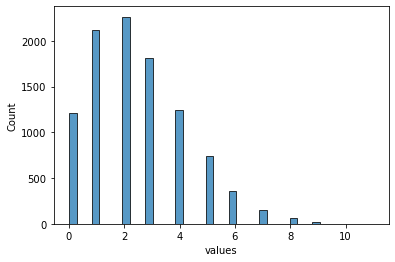

In [9]:
from scipy.optimize import minimize 
from scipy.stats import poisson
df2 = pd.read_csv('accidents.csv') 
dispersed_poisson_dist = df2['values'] 
sns.histplot(dispersed_poisson_dist)

In [10]:
def dispersed_poisson_log_likelihood(X,lam1,lam2,p):
    likelihood = p*poisson.pmf(X,lam1) + (1-p)*poisson.pmf(X,lam2) 
    return (-1)*np.sum(np.log(likelihood))

def bootstrap_CI(X,m,alpha): 
    n = len(X)
    X_resample = np.random.choice(X, size=(m,n)) 
    mles = np.zeros((m,3))
    for i in range(0, m):
        f = lambda x: dispersed_poisson_log_likelihood(X_resample[i,:],lam1=x[0],lam2=x[ 1],p=x[2])
        res = minimize(f, [1,2,0.5], bounds=((0, None), (0, None),(0,None)))
        mles[i,:] = res.x
    lower_bound = np.percentile(mles, 100*(alpha/2),axis=0) 
    upper_bound = np.percentile(mles, 100*(1-alpha/2),axis=0) 
    return (lower_bound, upper_bound, mles)

lower,upper,mle = bootstrap_CI(dispersed_poisson_dist,m=100,alpha=0.05) 
#print("Maximum Likelihood Estimates for 100 samples :\n",mle) 
print("Bootstrap Confidence Interval for Lambda_1 :",(lower[0],upper[0])) 
print("Bootstrap Confidence Interval for Lambda_2 :",(lower[1],upper[1])) 
print("Bootstrap Confidence Interval for p :",(lower[2],upper[2]))

Bootstrap Confidence Interval for Lambda_1 : (1.1523665185131682, 1.5111944425796708)
Bootstrap Confidence Interval for Lambda_2 : (2.975879831025735, 3.173883226283826)
Bootstrap Confidence Interval for p : (0.265263314265458, 0.4174404762973719)


# Hypothesis Testing

In [11]:
def hypo_test(df,alpha,sigma,mue_0=0):
    n = len(df)
    sample_mean = np.mean(df)
    z_alpha_2 = norm.ppf(1-alpha/2)
    lb = sample_mean - z_alpha_2*sigma/np.sqrt(n)
    ub = sample_mean + z_alpha_2*sigma/np.sqrt(n)
    p_value = 2*(1-norm.cdf((sample_mean-mue_0)/(sigma/np.sqrt(n))))
    if p_value < alpha:
        return ('Rejected',(lb,ub),p_value)
    else:
        return ('Not Rejected',(lb,ub),p_value)

In [12]:
hypo_test(normal_dist_values,alpha=0.05,sigma=0.3)

('Rejected', (0.15001675953234475, 0.4536530743839432), 9.752354554604103e-05)

In [13]:
def hypo_test_t(df,alpha,mue_0=0):
    n = len(df)
    sample_mean = np.mean(df)
    sample_sd = np.std(df,ddof=1)
    t_alpha_2 = t.ppf(1-alpha/2,n-1)
    lb = sample_mean - t_alpha_2*(sample_sd/np.sqrt(n))
    ub = sample_mean + t_alpha_2*(sample_sd/np.sqrt(n))
    p_value = 2*(1-t.cdf((sample_mean-mue_0)/(sample_sd/np.sqrt(n)),n-1))
    if p_value < alpha:
        return ('Rejected',(lb,ub),p_value)
    else:
        return ('Not Rejected',(lb,ub),p_value)

In [14]:
hypo_test_t(df=normal_dist_values,alpha=0.05)

('Rejected', (0.15348928571865278, 0.45018054819763514), 0.0006483218183379602)

In [15]:
def hypo_test_bootstrap(df,alpha,m,mue_0=0):
    n = len(df)
    sample = np.random.choice(df,replace=True,size=(m,n))
    mle = np.mean(sample,axis=1)
    p_value = percentileofscore(mle,mue_0)/100
    lb = np.percentile(mle,100*alpha/2)
    ub = np.percentile(mle,100*(1-alpha/2))
    if p_value < alpha:
        return ('Rejected',(lb,ub),p_value)
    else :
        return ('Not Rejected',(lb,ub),p_value)


In [16]:
hypo_test_bootstrap(normal_dist_values,alpha=0.05,m=100)   

('Rejected', (0.15527012415817693, 0.42384027382885436), 0.0)

# Regression Confidence and Prediction Intervals

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import norm

In [18]:
alpha = 1.0
beta = 0.25
n=30
X = np.arange(1,n+1)
eps = norm.rvs(loc=0,scale=1,size=(n,))

In [19]:
Y = alpha+beta*X + eps

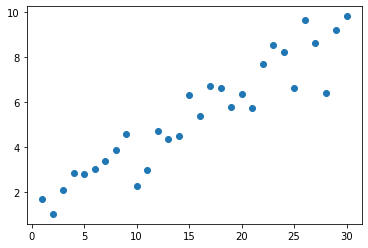

In [20]:
plt.scatter(X,Y)

In [21]:
df = pd.DataFrame(data={'x':X,'y':Y})

In [22]:
def reg_coef(df):
    X = df['x']
    Y = df['y']
    b = (np.sum(X*Y)-np.mean(X)*np.sum(Y))/(np.sum(X**2) - n*(np.mean(X)**2))
    a = np.mean(Y) - b*np.mean(X)
    return a,b
    
def residuals(df,alpha,beta):
    X = df['x']
    Y = df['y']
    eps = Y-beta*X-alpha
    return eps
    
    

In [23]:
def bootstrap_CI(df,m,alpha,x0):
    y_bs = np.zeros(shape=(m,))
    for i in range(0,m):
        df_resample = df.sample(n=len(df),replace=True)
        alpha,beta = reg_coef(df_resample)
        y_bs[i] = alpha + beta*x0
    lower_bound = np.percentile(y_bs,100*(alpha/2))
    upper_bound = np.percentile(y_bs,100*(1-alpha/2))
    return (lower_bound,upper_bound)

In [24]:
bootstrap_CI(df,100,0.05,31)

(9.808181447342035, 9.331606573904507)

In [25]:
def bootstrap_PI(df,m,alpha,x0):
    y_bs = np.zeros(shape=(m,))
    for i in range(0,m):
        df_resample = df.sample(n=len(df),replace=True)
        alpha,beta = reg_coef(df_resample)
        eps = residuals(df_resample,alpha,beta)
        y_bs[i] = alpha + beta*x0 + np.random.choice(eps)
    lower_bound = np.percentile(y_bs,100*(alpha/2))
    upper_bound = np.percentile(y_bs,100*(1-alpha/2))
    return (lower_bound,upper_bound)

In [26]:
bootstrap_PI(df,100,0.05,31)

(9.703538394476155, 9.544104796844652)

# Ordinary Least Squares

In [27]:
from statsmodels.api import OLS
from sklearn import datasets

In [28]:
data = datasets.load_diabetes()

In [29]:
X = pd.DataFrame(data=data['data'],columns=data['feature_names']).drop(['s1','s2','s3','s4','s5','s6'],axis=1)
y = pd.DataFrame(data = data['target'],columns=['outcome'])


In [30]:
lm = OLS(y,X)
res = lm.fit()

In [31]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                outcome   R-squared (uncentered):                   0.082
Model:                            OLS   Adj. R-squared (uncentered):              0.073
Method:                 Least Squares   F-statistic:                              9.734
Date:                Mon, 19 Apr 2021   Prob (F-statistic):                    1.50e-07
Time:                        15:35:11   Log-Likelihood:                         -2879.7
No. Observations:                 442   AIC:                                      5767.
Df Residuals:                     438   BIC:                                      5784.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age           37.2412    175.485      0.212      0.832    -307.655     382.138
sex         -106.5775    170.032     -0.627      0.531    -440.757     227.602
bmi          787.1793    179.061      4.396      0.000     435.254    1139.105
bp           416.6738    190.202      2.191      0.029      42.852     790.495
==============================================================================
Omnibus:                        9.858   Durbin-Watson:                   0.258
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                6.464
Skew:                           0.146   Prob(JB):                       0.0395
Kurtosis:                       2.485   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Machine Learning

In [32]:
df = pd.read_csv('titanic.csv',index_col=0)

In [33]:
y = df['Survived']
cat_cols = ['Pclass','Sex']
cont_cols = ['SibSp','Parch','Fare']
ord_cols = ['Age']
X = df[cat_cols+cont_cols+ord_cols]

In [34]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

# Feature Engineering and Data Preprocessing

In [35]:
cat_pipe = Pipeline([('oh',OneHotEncoder(handle_unknown='ignore'))])
cont_pipe = Pipeline([('pf',PolynomialFeatures()),
                      ('scale',StandardScaler())
                     ])
ord_pipe = Pipeline([('impute',SimpleImputer(strategy='median')),
                    ('bin',KBinsDiscretizer(n_bins=5,strategy='uniform'))
                    ])
ct = ColumnTransformer([('cat',cat_pipe,cat_cols),
                       ('cont',cont_pipe,cont_cols),
                       ('ord',ord_pipe,ord_cols)
                       ])

# Logistic Regression

In [36]:
params = {'logreg__C':np.logspace(-1,2,20),
             'ct__cont__pf__degree':[1,2,3,4]
             }
logreg_pipe = Pipeline([('ct',ct),
                ('logreg',LogisticRegression(max_iter=1500))
                ])
logreg_cv = GridSearchCV(logreg_pipe,param_grid=params,cv=10,scoring='neg_brier_score')
logreg_cv.fit(X_train,y_train)
logreg_cv.score(X_test,y_test)

-0.1425772940307229

# Decision Tree Classifier

In [37]:
params = {'dt__max_depth':np.arange(1,10,1),
          'dt__min_samples_split':np.arange(2,10,2),
          'dt__min_samples_leaf':np.arange(1,5,1),
          'ct__cont__pf__degree':[1,2,3,4]
         }
dt_pipe = Pipeline([('ct',ct),
                ('dt',DecisionTreeClassifier())
                ])
dt_cv = GridSearchCV(dt_pipe,param_grid=params,cv=5,scoring='neg_brier_score')
dt_cv.fit(X_train,y_train)
dt_cv.score(X_test,y_test)

-0.13295991447154487

In [38]:
dt_cv.best_params_

{'ct__cont__pf__degree': 1,
 'dt__max_depth': 5,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 8}

# Gradient Boosted Classifier

In [39]:
params = {'gbt__max_depth':np.arange(1,10,1),
          'gbt__min_samples_split':np.arange(2,10,2),
          'gbt__min_samples_leaf':np.arange(1,5,1),
          'ct__cont__pf__degree':[1,2,3,4],
         }
gbt_pipe = Pipeline([('ct',ct),
                ('gbt',GradientBoostingClassifier())
                ])
gbt_cv = GridSearchCV(gbt_pipe,param_grid=params,cv=5,scoring='neg_brier_score')
gbt_cv.fit(X_train,y_train)
gbt_cv.score(X_test,y_test)

-0.1423330961820393

In [40]:
gbt_cv.best_params_

{'ct__cont__pf__degree': 1,
 'gbt__max_depth': 2,
 'gbt__min_samples_leaf': 1,
 'gbt__min_samples_split': 2}